In [ ]:
%pip install scikit-learn matplotlib

Generated 400 training data points.
Training the GP surrogate model...
Training complete.
Learned GP Kernel: 22.5**2 * Matern(length_scale=[54.4, 3.05], nu=2.5) + WhiteKernel(noise_level=0.0108)
Predicting on the plot grid...


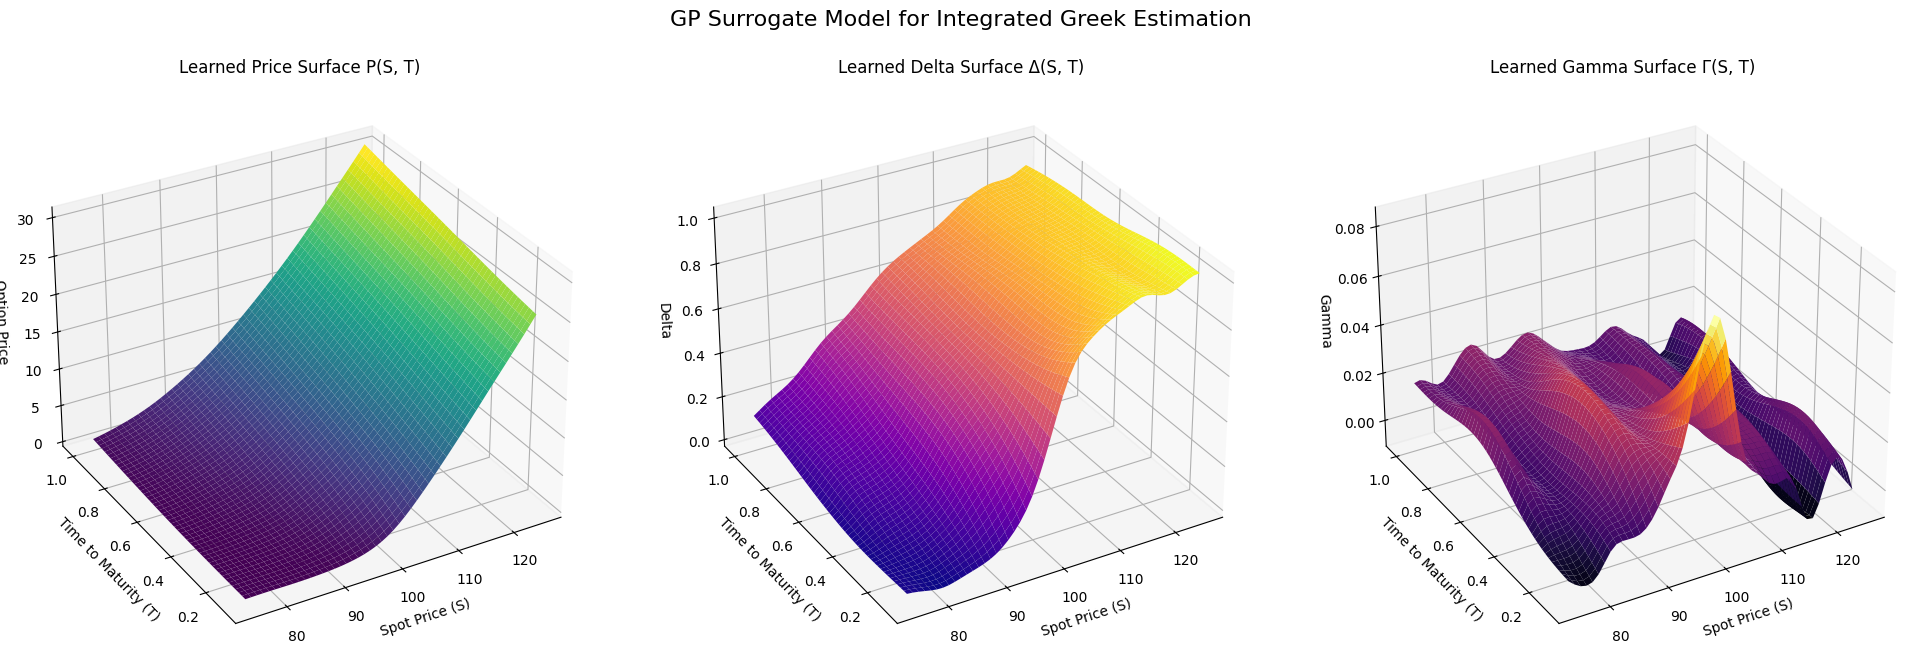

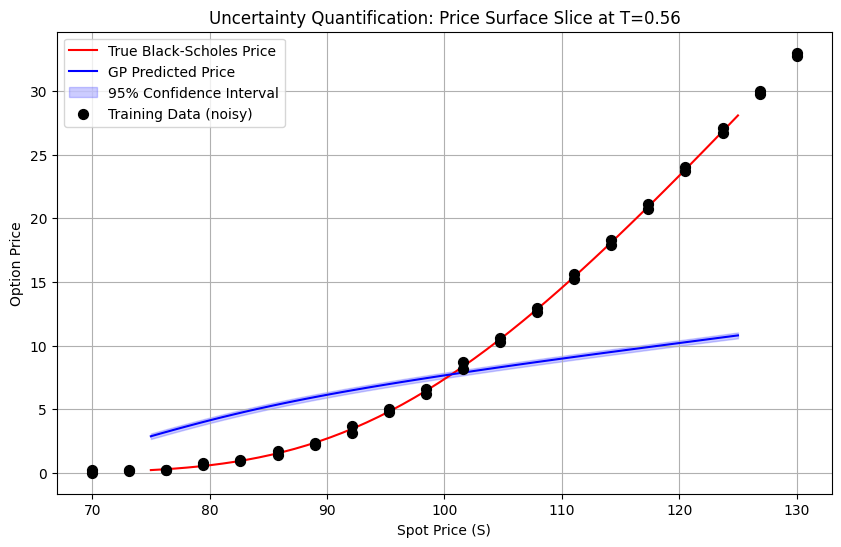

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel

# --- Step 1: Generate Dummy Training Data ---
# We will generate dummy data using the Black-Scholes model.
# This allows us to have a "true" price to which we can add noise,
# simulating real-world, imperfect observations.[3]

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculates the Black-Scholes price for a European call option.
    """
    # Handle array inputs for T
    T = np.array(T)
    if np.any(T <= 0):
        # If any T is <= 0, return the intrinsic value for those points
        call_price = np.where(T <= 0, np.maximum(0, S - K), 0)
        # Calculate Black-Scholes for T > 0 and combine
        T_positive = T[T > 0]
        if T_positive.size > 0:
            S_positive = S[T > 0] if isinstance(S, np.ndarray) else S
            d1 = (np.log(S_positive / K) + (r + 0.5 * sigma ** 2) * T_positive) / (sigma * np.sqrt(T_positive))
            d2 = d1 - sigma * np.sqrt(T_positive)
            bs_price = (S_positive * norm.cdf(d1) - K * np.exp(-r * T_positive) * norm.cdf(d2))
            call_price[T > 0] = bs_price
        return call_price
    else:
        # Standard Black-Scholes for all T > 0
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
        return call_price


# --- Option & Model Parameters ---
K = 100.0  # Strike price
r = 0.05   # Risk-free rate
sigma = 0.2 # Volatility
T_max = 1.0 # Max time to maturity

# --- Create a Training Set ---
# The geometry of the training set is critical. Space-filling designs are more
# effective than path-based data for learning the entire surface.[3]
# We'll use a grid of points for spot price (S) and time to maturity (tau).
n_samples_S = 20
n_samples_T = 20
S_space = np.linspace(70, 130, n_samples_S)
T_space = np.linspace(0.01, T_max, n_samples_T)
S_grid, T_grid = np.meshgrid(S_space, T_space)

X_train = np.vstack([S_grid.ravel(), T_grid.ravel()]).T

# Calculate the "true" prices using Black-Scholes
y_true = black_scholes_call(X_train[:, 0], K, X_train[:, 1], r, sigma)

# Add noise to simulate real-world data (e.g., from a Monte Carlo engine) [3]
noise_level = 0.1
noise = np.random.normal(0, noise_level, y_true.shape)
y_train = y_true + noise

print(f"Generated {len(y_train)} training data points.")

# --- Step 2: Specify and Train the GP Surrogate ---
# We use a Gaussian Process Regressor to learn the option price surface P(S, T).
# The choice of kernel is crucial as it determines the smoothness of the learned surface.
# A Matérn-5/2 kernel is recommended as it is twice-differentiable,
# allowing for the calculation of both Delta and Gamma.[3]

# Kernel selection: Matérn with nu=2.5 (twice differentiable) + WhiteKernel for noise
kernel = 1.0 * Matern(length_scale=[1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=noise_level)

# Instantiate the GP model
# The model will optimize the kernel's hyperparameters during the fitting process.
gp_surrogate = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

print("Training the GP surrogate model...")
gp_surrogate.fit(X_train, y_train)
print("Training complete.")
print(f"Learned GP Kernel: {gp_surrogate.kernel_}")


# --- Step 3: Integrated Greek Estimation ---
# Once the price surface is learned, we can differentiate it to get the Greeks.
# This ensures all Greeks are self-consistent.[3] We use finite differences
# on the GP's predictions to approximate the derivatives.

def get_greeks_from_gp(gp_model, S, T, h=0.01):
    """
    Calculates Delta and Gamma by differentiating the trained GP surrogate.
    """
    # Predict price at S, S+h, and S-h
    points_to_predict = np.array([[S, T], [S + h, T], [S - h, T]])
    prices = gp_model.predict(points_to_predict)

    price_S = prices[0]
    price_S_plus_h = prices[1]
    price_S_minus_h = prices[2]

    # Delta: First derivative approximation (central difference)
    delta = (price_S_plus_h - price_S_minus_h) / (2 * h)

    # Gamma: Second derivative approximation
    gamma = (price_S_plus_h - 2 * price_S + price_S_minus_h) / (h ** 2)

    return delta, gamma

# --- Step 4: Visualization and Uncertainty Quantification ---
# Create a finer grid for plotting the learned surfaces.
S_plot = np.linspace(75, 125, 50)
T_plot = np.linspace(0.1, T_max, 50)
S_plot_grid, T_plot_grid = np.meshgrid(S_plot, T_plot)
X_plot = np.vstack([S_plot_grid.ravel(), T_plot_grid.ravel()]).T

# Predict prices and get uncertainty estimates from the GP
print("Predicting on the plot grid...")
price_pred, price_std = gp_surrogate.predict(X_plot, return_std=True)
price_pred_grid = price_pred.reshape(S_plot_grid.shape)
price_std_grid = price_std.reshape(S_plot_grid.shape)

# Calculate Greeks across the plot grid
delta_pred_grid = np.zeros_like(price_pred_grid)
gamma_pred_grid = np.zeros_like(price_pred_grid)

for i in range(len(S_plot)):
    for j in range(len(T_plot)):
        s_val = S_plot_grid[i, j]
        t_val = T_plot_grid[i, j]
        delta, gamma = get_greeks_from_gp(gp_surrogate, s_val, t_val)
        delta_pred_grid[i, j] = delta
        gamma_pred_grid[i, j] = gamma

# --- Plotting the Results ---

# 1. Learned Price Surface
fig = plt.figure(figsize=(20, 7))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(S_plot_grid, T_plot_grid, price_pred_grid, cmap='viridis')
ax1.set_title('Learned Price Surface P(S, T)')
ax1.set_xlabel('Spot Price (S)')
ax1.set_ylabel('Time to Maturity (T)')
ax1.set_zlabel('Option Price')
ax1.view_init(30, -120)

# 2. Learned Delta Surface
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(S_plot_grid, T_plot_grid, delta_pred_grid, cmap='plasma')
ax2.set_title('Learned Delta Surface Δ(S, T)')
ax2.set_xlabel('Spot Price (S)')
ax2.set_ylabel('Time to Maturity (T)')
ax2.set_zlabel('Delta')
ax2.view_init(30, -120)

# 3. Learned Gamma Surface
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(S_plot_grid, T_plot_grid, gamma_pred_grid, cmap='inferno')
ax3.set_title('Learned Gamma Surface Γ(S, T)')
ax3.set_xlabel('Spot Price (S)')
ax3.set_ylabel('Time to Maturity (T)')
ax3.set_zlabel('Gamma')
ax3.view_init(30, -120)

plt.suptitle('GP Surrogate Model for Integrated Greek Estimation', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 4. Uncertainty Quantification Plot
# A key advantage of GPs is their ability to provide confidence intervals
# around predictions, quantifying the model's own uncertainty.[3]
plt.figure(figsize=(10, 6))
# Take a slice of the surface at a fixed time to maturity
t_slice_idx = len(T_plot) // 2
t_slice_val = T_plot[t_slice_idx]

# Get predictions and true values for the slice
price_slice_pred = price_pred_grid[:, t_slice_idx]
price_slice_std = price_std_grid[:, t_slice_idx]
price_slice_true = black_scholes_call(S_plot, K, t_slice_val, r, sigma)

plt.plot(S_plot, price_slice_true, 'r-', label='True Black-Scholes Price')
plt.plot(S_plot, price_slice_pred, 'b-', label='GP Predicted Price')
plt.fill_between(S_plot,
                 price_slice_pred - 1.96 * price_slice_std,
                 price_slice_pred + 1.96 * price_slice_std,
                 alpha=0.2, color='blue', label='95% Confidence Interval')

# Plot the training data points that fall near this slice
s_train_slice = X_train[(X_train[:, 1] > t_slice_val - 0.05) & (X_train[:, 1] < t_slice_val + 0.05)]
y_train_slice = y_train[(X_train[:, 1] > t_slice_val - 0.05) & (X_train[:, 1] < t_slice_val + 0.05)]
plt.scatter(s_train_slice[:,0], y_train_slice, c='k', s=50, zorder=10, edgecolors=(0, 0, 0), label='Training Data (noisy)')

plt.title(f'Uncertainty Quantification: Price Surface Slice at T={t_slice_val:.2f}')
plt.xlabel('Spot Price (S)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()